# 使用Gluon对CIFAR10进行分类

In [1]:
import mxnet as mx
import numpy as np
import utils
import shutil
import os
import logging
logging.basicConfig(level=logging.INFO)

from mxnet import nd
from mxnet import gluon
from mxnet import image 
from mxnet import metric
from mxnet import autograd

%matplotlib inline 
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
import matplotlib.pyplot as plt

mx.random.seed(2018)

## 整理数据

In [2]:
def reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio):
    # 整理label
    with open(os.path.join(data_dir, label_file), 'r') as f:
        label_file = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in label_file]
        idx_label = dict((int(idx), label) for idx, label in tokens)
    labels = set(idx_label.values())
    
    # 设置验证集比例
    num_train = len(os.listdir(os.path.join(data_dir, train_dir)))
    num_train_tuning = num_train * (1 - valid_ratio)
    assert 0 < num_train_tuning < num_train
    num_train_tuning_per_label = num_train_tuning // len(labels)
    
    # 整理训练集和验证集
    label_count = dict()
    def mkdir_if_not_exist(path):
        if not os.path.exists(os.path.join(*path)):
            os.makedirs(os.path.join(*path))
            
    for train_file in os.listdir(os.path.join(data_dir, train_dir)):
        idx = int(train_file.split('.')[0])
        train_label = idx_label[idx]
        mkdir_if_not_exist([data_dir, input_dir, 'train_valid', train_label])
        shutil.copy(os.path.join(data_dir, train_dir, train_file),
                   os.path.join(data_dir, input_dir, 'train_valid', train_label))
        # 划分训练集和验证集
        if train_label not in label_count or label_count[train_label] < num_train_tuning_per_label:
            mkdir_if_not_exist([data_dir, input_dir, 'train', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'train', train_label))
            label_count[train_label] = label_count.get(train_label, 0) + 1
        else:
            mkdir_if_not_exist([data_dir, input_dir, 'valid', train_label])
            shutil.copy(os.path.join(data_dir, train_dir, train_file),
                       os.path.join(data_dir, input_dir, 'valid', train_label))
    
    # 整理测试集
    mkdir_if_not_exist([data_dir, input_dir, 'test', 'unknown'])
    for test_file in os.listdir(os.path.join(data_dir, test_dir)):  
        shutil.copy(os.path.join(data_dir, test_dir, test_file),
                   os.path.join(data_dir, input_dir, 'test', 'unknown'))

In [3]:
data_dir = '../data/kaggle_cifar10'
train_dir = 'train'
test_dir = 'test'
input_dir = 'train_valid_test'
label_file = 'trainLabels.csv'
valid_ratio = .1

if not os.path.exists(os.path.join(data_dir, input_dir, test_dir)):
    reorg_cifar10(data_dir, train_dir, test_dir, input_dir, label_file, valid_ratio)

## 读取数据并增广

In [4]:
train_augs = [
    # 该值为计算得出
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4456]), 
                            std=nd.array([0.2023, 0.1994, 0.2010])),
    image.HorizontalFlipAug(.6),
    # image.RandomSizedCropAug((32, 32), 0.8, (0.5, 2))
    # image.BrightnessJitterAug(.5),
    # image.ColorJitterAug
]

test_augs = [
    image.ColorNormalizeAug(mean=nd.array([0.4914, 0.4822, 0.4465]), 
                            std=nd.array([0.2023, 0.1994, 0.2010]))
]

def transform(data, label, augs):
    img = data.astype(np.float32)
    for aug in augs:
        img = aug(img)
    img = img.clip(0, 255).transpose((2,0,1)) / 255
    return img, nd.array([label]).asscalar().astype(np.float32)

############################################################################
def transform_train(data, label):
    im = data.astype('float32') / 255
    im = nd.transpose(im, (2,0,1))
    im = nd.expand_dims(im, axis=0)
    im = nd.pad(im, pad_width=(0,0,0,0,4,4,4,4), mode='constant', constant_value=0)[0]
    im = nd.transpose(im, (1,2,0))
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32), resize=0,
                        rand_crop=True, rand_resize=False, rand_mirror=True,
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]),
                        brightness=0, contrast=0,
                        saturation=0, hue=0,
                        pca_noise=0, rand_gray=0, inter_method=2)
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))

def transform_test(data, label):
    im = data.astype('float32') / 255
    auglist = image.CreateAugmenter(data_shape=(3, 32, 32),
                        mean=np.array([0.4914, 0.4822, 0.4465]),
                        std=np.array([0.2023, 0.1994, 0.2010]))
    for aug in auglist:
        im = aug(im)
    im = nd.transpose(im, (2,0,1))
    return (im, nd.array([label]).asscalar().astype('float32'))
############################################################################

input_str = data_dir + '/' + input_dir + '/'

# 读取数据
train_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train', transform=transform_train)
valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'valid', transform=transform_test)
train_valid_ds = gluon.data.vision.ImageFolderDataset(input_str + 'train_valid', transform=transform_train)
test_ds = gluon.data.vision.ImageFolderDataset(input_str + 'test', transform=transform_test)

batch_size = 64
train_data = gluon.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
valid_data = gluon.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, last_batch='keep')
train_valid_data = gluon.data.DataLoader(train_valid_ds, batch_size=batch_size, last_batch='keep')
test_data = gluon.data.DataLoader(test_ds, batch_size=batch_size, shuffle=False, last_batch='keep')

(64, 3, 32, 32)


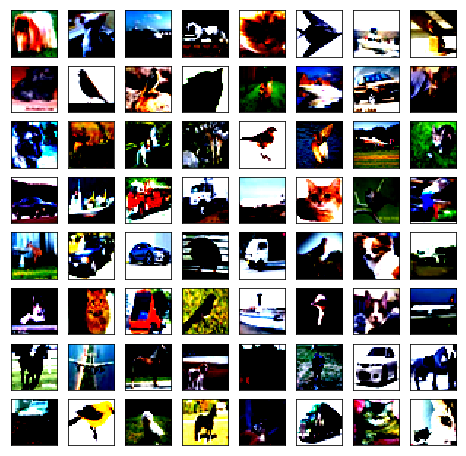

In [9]:
for data, label in valid_data:
    print(data.shape)
    break

utils.show_images(data.transpose((0,2,3,1)), 8, 8, figsize=(8,8))

## SparseNet

论文地址：https://arxiv.org/abs/1801.05895

In [18]:
'''
BN_ReLU_CONV: 非线性单元
'''
def BN_ReLU_CONV(channels, kernel_size, strides=1, padding=0, erase_relu=False):
    basic = gluon.nn.HybridSequential()
    with basic.name_scope():
        basic.add(gluon.nn.BatchNorm(axis=1, epsilon=2e-5))
        if not erase_relu:
            basic.add(gluon.nn.Activation('relu'))
        basic.add(gluon.nn.Conv2D(channels, kernel_size=kernel_size, 
                                  strides=strides, padding=padding)) 
    return basic


'''
SparseUnit: Sparse单元
'''
class SparseUnit(gluon.HybridBlock):
    def __init__(self, channels, bottleneck=False, **kwargs):
        super().__init__(**kwargs)
        # bottleneck unit
        self.bottleneck = bottleneck
        with self.name_scope():
            unit = self.unit = gluon.nn.HybridSequential()
            if self.bottleneck:
                unit.add(BN_ReLU_CONV(channels, kernel_size=1))
            unit.add(BN_ReLU_CONV(channels, kernel_size=3, padding=1))
            
    def hybrid_forward(self, F, X):
        return self.unit(X)

'''
fetch_exponential_idx: 返回列表中的2^k的index
'''
def fetch_exponential_idx(x_list):
    count = len(x_list)
    i = 1    
    inputs = []
    while i <= count:
        inputs.append(x_list[count - i])
        i *= 2
    return inputs

'''
SparseBlock: Sparse block层
'''
class SparseBlock(gluon.HybridBlock):
    def __init__(self, nDenseBlock, growth_rate, bottleneck=False, droprate=.0, **kwargs):
        super().__init__(**kwargs)
        self.nDenseBlock = nDenseBlock
        with self.name_scope():
            net = self.net = gluon.nn.HybridSequential()
            for i in range(nDenseBlock):
                blk = gluon.nn.HybridSequential()
                if bottleneck:
                    interchannels = 4 * growth_rate
                    blk.add(BN_ReLU_CONV(interchannels, kernel_size=1, erase_relu=True))
                    if droprate > .0:
                        blk.add(gluon.nn.Dropout(droprate)) 
                    blk.add(BN_ReLU_CONV(growth_rate, kernel_size=3, padding=1))
                    if droprate > .0:
                        blk.add(gluon.nn.Dropout(droprate)) 
                else:
                    blk.add(BN_ReLU_CONV(growth_rate, kernel_size=3, padding=1))
                    if droprate > .0:
                        blk.add(gluon.nn.Dropout(droprate)) 
                # add BN layer each
                blk.add(gluon.nn.BatchNorm(axis=1, epsilon=2e-5))
                net.add(blk)
        
    def hybrid_forward(self, F, X):
        X_list = [X]
        for i, blk in enumerate(self.net):
            X = blk(X)
            X_list.append(X)
            expidx_output = fetch_exponential_idx(X_list)
            
            # concat
            tmp = expidx_output[0] 
            for out in expidx_output[1:]:
                tmp = F.concat(tmp, out, dim=1)
            X = tmp
        # print('SparseBlk - ', X.shape)
        return X

'''
TransitionLayer: 过渡层
'''
def TransitionLayer(channels, droprate=0.0):
    layer = gluon.nn.HybridSequential()
    with layer.name_scope():
        layer.add(BN_ReLU_CONV(channels, kernel_size=1))
        if droprate > 0.0:
            layer.add(gluon.nn.Dropout(droprate))
        layer.add(gluon.nn.AvgPool2D(pool_size=2, strides=2))
    return layer

'''
num_classes: 待预测的类别数
num_sparseblk_count: 共需要加入几个SparseBlock
depth: 网络总的层数
reduction: transitionlayer的输出通道数减少比例
droprate: transitionlayer的dropout层的丢弃比例
growth_rate: 每个SparseBlock的固定输出通道数
init_channels: Init Conv Layer的初始输出通道数
bottleneck: 是否为bottleneck
verbose: 打印调试信息
'''
class SparseNet(gluon.HybridBlock):
    def __init__(self, num_classes, num_sparseblk_count, depth, reduction=.5, droprate=0.0, growth_rate=12, 
                 bottleneck=False, verbose=False, **kwargs):
        super().__init__(**kwargs)
        self.verbose = verbose
        with self.name_scope(): 
            net = self.net = gluon.nn.HybridSequential() # 整合之后的网络
            
            # 每个SpraseBlock有多少个block
            nDenseBlock = (depth - 4) // num_sparseblk_count
            # 如果是bottleneck，那么每个nDenseBlock减半，因为每个bottleneck中有两个Conv2D
            if bottleneck:
                nDenseBlock //= 2
            else:
                reduction = 1
            
            # Init Conv Layer
            init_channels = growth_rate
            net.add(gluon.nn.Conv2D(init_channels, kernel_size=3, padding=1))
            
            # Sparse Connected Layer
            sparse_output_channel = init_channels
            for idx in range(num_sparseblk_count):
                b2 = gluon.nn.HybridSequential()
                
                # Adding SparseBlock
                b2.add(SparseBlock(nDenseBlock, growth_rate, bottleneck))
                
                # 统计每个sparseblock的输出通道数 用于给过渡层以固定的reduction比例减少通道数
                sparse_output_filter = [sparse_output_channel]
                for _ in range(nDenseBlock):
                    sparse_output_filter.append(growth_rate)
                sparse_output_channel = sum(fetch_exponential_idx(sparse_output_filter)) * reduction
                
                # 过渡层比SparseBlock层少一层 
                if idx != num_sparseblk_count - 1:
                    # Transition Layer 每次过渡层将输出通道减半
                    b2.add(TransitionLayer(int(sparse_output_channel), droprate))
                net.add(b2)
            
            ############# final feature layer
            net.add(gluon.nn.BatchNorm(axis=1))
            net.add(gluon.nn.Activation('relu'))
            #############        
            
            # Classification Layer
            b3 = gluon.nn.HybridSequential()
            b3.add(
                gluon.nn.GlobalAvgPool2D(),
                gluon.nn.Dense(num_classes)
            )
            net.add(b3)
            
    def hybrid_forward(self, F, X):
        out = X
        for i, blk in enumerate(self.net):
            out = blk(out)
            # if self.verbose:
                # print("blk %d : %s" % (i+1, out.shape))
        return out

In [7]:
sparsenet = SparseNet(num_classes=10, num_sparseblk_count=3, depth=100, growth_rate=24, verbose=True)
sparsenet.initialize()
sample = nd.random.uniform(shape=(64, 3, 32, 32))
y = sparsenet(sample)

In [8]:
from time import time

def train(net, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx):
    assert isinstance(ctx, mx.Context)
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'nag', {'learning_rate': lr, 'momentum': 0.9, 'wd': wd})
    niter = 0
    moving_loss = .0
    smoothing_constant = .9
    
    if valid_data is not None:
        best_valid_acc = .0
    for epoch in range(num_epochs):
        if 0 <= epoch <= 1:
            trainer.set_learning_rate(0.01)
        if epoch == 2:
            trainer.set_learning_rate(0.1)
        if epoch == 150:
            trainer.set_learning_rate(0.01)
        if epoch == 225:
            trainer.set_learning_rate(0.001)
        if epoch == 260:
            trainer.set_learning_rate(0.0001)
        if epoch == 280:
            trainer.set_learning_rate(0.00005)
        start = time()
        for data, label in train_data:
            data = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            with autograd.record():
                output = net(data)
                l = loss(output, label)
            l.backward()
            trainer.step(data.shape[0])    
            
            niter += 1   
            curr_loss = nd.mean(l).asscalar()
            moving_loss = smoothing_constant * moving_loss + (1-smoothing_constant) * curr_loss
            estimated_loss = moving_loss / (1 - smoothing_constant**niter)
        
        train_acc = utils.evaluate_accuracy_gluon(train_data, net, ctx)
        
        if valid_data is not None:
            valid_acc, valid_loss = utils.evaluate_accuracy_gluon(valid_data, net, ctx, loss_avg=True)
            print("[Epoch %d] Train Moving Loss : %.5f, Test Loss : %.5f, Train Acc : %.5f, Test Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss, valid_loss, train_acc, valid_acc, time() - start))

            if valid_acc > best_valid_acc:
                best_valid_acc = valid_acc
                net.save_params('sparsenet-cifar10-%d-%.5f.params' % (epoch, best_valid_acc))
        else:
            print("[Epoch %d] Train Moving Loss : %.5f, Train Acc : %.5f, Time Consume %f s."
                  % (epoch, estimated_loss,train_acc, time() - start))

In [9]:
num_epochs = 300
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2

ctx = mx.gpu()
sparsenet = SparseNet(num_classes=10, num_sparseblk_count=3, depth=100, growth_rate=36, 
                      bottleneck=True, verbose=True)
# He Xaiver Initializer
sparsenet.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(factor_type='in', 
                                                                   rnd_type='gaussian', magnitude=2.))
sparsenet.hybridize()
train(sparsenet, train_data, valid_data, num_epochs, lr, wd, lr_period, lr_decay, ctx)

[Epoch 0] Train Moving Loss : 0.97464, Test Loss : 1.07403, Train Acc : 0.62933, Test Acc : 0.62860, Time Consume 345.456381 s.
[Epoch 1] Train Moving Loss : 0.77957, Test Loss : 0.81302, Train Acc : 0.73438, Test Acc : 0.72700, Time Consume 250.188727 s.
[Epoch 2] Train Moving Loss : 0.78182, Test Loss : 1.07175, Train Acc : 0.68020, Test Acc : 0.67380, Time Consume 246.554125 s.
[Epoch 3] Train Moving Loss : 0.67875, Test Loss : 0.84154, Train Acc : 0.72618, Test Acc : 0.72040, Time Consume 242.527439 s.
[Epoch 4] Train Moving Loss : 0.64566, Test Loss : 0.63716, Train Acc : 0.79220, Test Acc : 0.76880, Time Consume 245.120476 s.
[Epoch 5] Train Moving Loss : 0.50840, Test Loss : 0.61066, Train Acc : 0.80760, Test Acc : 0.79540, Time Consume 242.871748 s.
[Epoch 6] Train Moving Loss : 0.45098, Test Loss : 0.57686, Train Acc : 0.81429, Test Acc : 0.79580, Time Consume 242.753289 s.
[Epoch 7] Train Moving Loss : 0.48231, Test Loss : 0.53712, Train Acc : 0.83962, Test Acc : 0.81780, Tim

[Epoch 64] Train Moving Loss : 0.27485, Test Loss : 0.46864, Train Acc : 0.88944, Test Acc : 0.85720, Time Consume 244.216925 s.
[Epoch 65] Train Moving Loss : 0.23392, Test Loss : 0.46421, Train Acc : 0.88967, Test Acc : 0.85880, Time Consume 244.230823 s.
[Epoch 66] Train Moving Loss : 0.20845, Test Loss : 0.46504, Train Acc : 0.90278, Test Acc : 0.86240, Time Consume 244.430399 s.
[Epoch 67] Train Moving Loss : 0.28582, Test Loss : 0.32689, Train Acc : 0.92762, Test Acc : 0.88740, Time Consume 244.270482 s.
[Epoch 68] Train Moving Loss : 0.23263, Test Loss : 0.49446, Train Acc : 0.88162, Test Acc : 0.84840, Time Consume 244.045440 s.
[Epoch 69] Train Moving Loss : 0.28653, Test Loss : 0.33184, Train Acc : 0.93338, Test Acc : 0.89140, Time Consume 244.402240 s.
[Epoch 70] Train Moving Loss : 0.27187, Test Loss : 0.44064, Train Acc : 0.91102, Test Acc : 0.86340, Time Consume 244.297600 s.
[Epoch 71] Train Moving Loss : 0.19250, Test Loss : 0.29377, Train Acc : 0.93671, Test Acc : 0.90

[Epoch 128] Train Moving Loss : 0.17170, Test Loss : 0.39144, Train Acc : 0.91647, Test Acc : 0.87660, Time Consume 244.217836 s.
[Epoch 129] Train Moving Loss : 0.20258, Test Loss : 0.34420, Train Acc : 0.93249, Test Acc : 0.89120, Time Consume 244.388293 s.
[Epoch 130] Train Moving Loss : 0.23237, Test Loss : 0.38818, Train Acc : 0.91724, Test Acc : 0.88080, Time Consume 244.426223 s.
[Epoch 131] Train Moving Loss : 0.21653, Test Loss : 0.44867, Train Acc : 0.90364, Test Acc : 0.86080, Time Consume 244.428457 s.
[Epoch 132] Train Moving Loss : 0.24804, Test Loss : 0.35269, Train Acc : 0.92889, Test Acc : 0.88280, Time Consume 244.267797 s.
[Epoch 133] Train Moving Loss : 0.27042, Test Loss : 0.37488, Train Acc : 0.92291, Test Acc : 0.88460, Time Consume 244.257219 s.
[Epoch 134] Train Moving Loss : 0.18131, Test Loss : 0.31132, Train Acc : 0.93593, Test Acc : 0.90040, Time Consume 244.323032 s.
[Epoch 135] Train Moving Loss : 0.20626, Test Loss : 0.34096, Train Acc : 0.93362, Test Ac

[Epoch 192] Train Moving Loss : 0.00641, Test Loss : 0.19826, Train Acc : 0.99967, Test Acc : 0.94960, Time Consume 244.485301 s.
[Epoch 193] Train Moving Loss : 0.00895, Test Loss : 0.20048, Train Acc : 0.99980, Test Acc : 0.95020, Time Consume 244.545971 s.
[Epoch 194] Train Moving Loss : 0.00349, Test Loss : 0.20338, Train Acc : 0.99982, Test Acc : 0.94940, Time Consume 244.330167 s.
[Epoch 195] Train Moving Loss : 0.01633, Test Loss : 0.19453, Train Acc : 0.99978, Test Acc : 0.94960, Time Consume 244.300112 s.
[Epoch 196] Train Moving Loss : 0.01210, Test Loss : 0.19841, Train Acc : 0.99971, Test Acc : 0.94780, Time Consume 244.313448 s.
[Epoch 197] Train Moving Loss : 0.00788, Test Loss : 0.19771, Train Acc : 0.99962, Test Acc : 0.95220, Time Consume 244.442451 s.
[Epoch 198] Train Moving Loss : 0.00514, Test Loss : 0.19937, Train Acc : 0.99984, Test Acc : 0.94960, Time Consume 244.409175 s.
[Epoch 199] Train Moving Loss : 0.00378, Test Loss : 0.20318, Train Acc : 0.99971, Test Ac

[Epoch 256] Train Moving Loss : 0.00158, Test Loss : 0.19045, Train Acc : 1.00000, Test Acc : 0.95360, Time Consume 244.241177 s.
[Epoch 257] Train Moving Loss : 0.00146, Test Loss : 0.18760, Train Acc : 1.00000, Test Acc : 0.95280, Time Consume 244.300351 s.
[Epoch 258] Train Moving Loss : 0.00144, Test Loss : 0.18641, Train Acc : 0.99998, Test Acc : 0.95320, Time Consume 244.473499 s.
[Epoch 259] Train Moving Loss : 0.00239, Test Loss : 0.19470, Train Acc : 0.99996, Test Acc : 0.94960, Time Consume 244.317487 s.
[Epoch 260] Train Moving Loss : 0.00300, Test Loss : 0.18686, Train Acc : 1.00000, Test Acc : 0.95400, Time Consume 244.267023 s.
[Epoch 261] Train Moving Loss : 0.00137, Test Loss : 0.19292, Train Acc : 1.00000, Test Acc : 0.95300, Time Consume 244.368844 s.
[Epoch 262] Train Moving Loss : 0.07148, Test Loss : 0.19334, Train Acc : 1.00000, Test Acc : 0.95220, Time Consume 244.169782 s.
[Epoch 263] Train Moving Loss : 0.00383, Test Loss : 0.19402, Train Acc : 0.99998, Test Ac

In [10]:
import pandas as pd

ctx = mx.gpu()
num_epochs = 300
lr = 0.1
wd = 1e-4
lr_period = 50
lr_decay = .2

ctx = mx.gpu()
sparsenet = SparseNet(num_classes=10, num_sparseblk_count=3, depth=100, growth_rate=36, 
                      bottleneck=True, verbose=True)
# He Xaiver Initializer
sparsenet.collect_params().initialize(ctx=ctx, init=mx.init.Xavier(factor_type='in', 
                                                                   rnd_type='gaussian', magnitude=2.))
sparsenet.hybridize()
train(sparsenet, train_data, None, num_epochs, lr, wd, lr_period, lr_decay, ctx)

preds = []
for data, label in test_data:
    output = sparsenet(data.as_in_context(ctx))
    preds.extend(output.argmax(axis=1).astype(int).asnumpy())

sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key = lambda x:str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('submission.csv', index=False)

[Epoch 0] Train Moving Loss : 1.03354, Train Acc : 0.64556, Time Consume 237.338449 s.
[Epoch 1] Train Moving Loss : 0.72193, Train Acc : 0.75344, Time Consume 237.997346 s.
[Epoch 2] Train Moving Loss : 0.95621, Train Acc : 0.68304, Time Consume 237.990278 s.
[Epoch 3] Train Moving Loss : 0.71797, Train Acc : 0.73787, Time Consume 238.025865 s.
[Epoch 4] Train Moving Loss : 0.62546, Train Acc : 0.81780, Time Consume 237.752357 s.
[Epoch 5] Train Moving Loss : 0.48011, Train Acc : 0.83033, Time Consume 237.970368 s.
[Epoch 6] Train Moving Loss : 0.58060, Train Acc : 0.83678, Time Consume 237.583589 s.
[Epoch 7] Train Moving Loss : 0.48905, Train Acc : 0.79760, Time Consume 237.801789 s.
[Epoch 8] Train Moving Loss : 0.46674, Train Acc : 0.85482, Time Consume 237.921917 s.
[Epoch 9] Train Moving Loss : 0.44886, Train Acc : 0.86618, Time Consume 237.877661 s.
[Epoch 10] Train Moving Loss : 0.50246, Train Acc : 0.85084, Time Consume 237.692965 s.
[Epoch 11] Train Moving Loss : 0.38624, Tr

[Epoch 94] Train Moving Loss : 0.21961, Train Acc : 0.91900, Time Consume 237.588793 s.
[Epoch 95] Train Moving Loss : 0.20826, Train Acc : 0.92998, Time Consume 237.679477 s.
[Epoch 96] Train Moving Loss : 0.25823, Train Acc : 0.91424, Time Consume 237.624290 s.
[Epoch 97] Train Moving Loss : 0.22896, Train Acc : 0.90469, Time Consume 237.616297 s.
[Epoch 98] Train Moving Loss : 0.30440, Train Acc : 0.89342, Time Consume 237.625067 s.
[Epoch 99] Train Moving Loss : 0.20557, Train Acc : 0.90953, Time Consume 237.679573 s.
[Epoch 100] Train Moving Loss : 0.23909, Train Acc : 0.90387, Time Consume 237.790809 s.
[Epoch 101] Train Moving Loss : 0.28050, Train Acc : 0.92251, Time Consume 237.763983 s.
[Epoch 102] Train Moving Loss : 0.19584, Train Acc : 0.92584, Time Consume 243.024187 s.
[Epoch 103] Train Moving Loss : 0.23588, Train Acc : 0.91391, Time Consume 239.332781 s.
[Epoch 104] Train Moving Loss : 0.20046, Train Acc : 0.93611, Time Consume 239.190431 s.
[Epoch 105] Train Moving Lo

[Epoch 187] Train Moving Loss : 0.01023, Train Acc : 0.99962, Time Consume 237.543504 s.
[Epoch 188] Train Moving Loss : 0.00843, Train Acc : 0.99969, Time Consume 237.571726 s.
[Epoch 189] Train Moving Loss : 0.01629, Train Acc : 0.99971, Time Consume 237.648113 s.
[Epoch 190] Train Moving Loss : 0.04456, Train Acc : 0.99978, Time Consume 237.765428 s.
[Epoch 191] Train Moving Loss : 0.00626, Train Acc : 0.99944, Time Consume 237.718134 s.
[Epoch 192] Train Moving Loss : 0.02579, Train Acc : 0.99976, Time Consume 237.806707 s.
[Epoch 193] Train Moving Loss : 0.00526, Train Acc : 0.99969, Time Consume 237.713586 s.
[Epoch 194] Train Moving Loss : 0.00570, Train Acc : 0.99969, Time Consume 237.561871 s.
[Epoch 195] Train Moving Loss : 0.00914, Train Acc : 0.99951, Time Consume 237.582276 s.
[Epoch 196] Train Moving Loss : 0.00747, Train Acc : 0.99973, Time Consume 237.640369 s.
[Epoch 197] Train Moving Loss : 0.00675, Train Acc : 0.99976, Time Consume 237.678382 s.
[Epoch 198] Train Mov

[Epoch 280] Train Moving Loss : 0.00069, Train Acc : 1.00000, Time Consume 237.577075 s.
[Epoch 281] Train Moving Loss : 0.00439, Train Acc : 1.00000, Time Consume 237.660288 s.
[Epoch 282] Train Moving Loss : 0.00293, Train Acc : 1.00000, Time Consume 237.550333 s.
[Epoch 283] Train Moving Loss : 0.00287, Train Acc : 1.00000, Time Consume 237.702103 s.
[Epoch 284] Train Moving Loss : 0.00182, Train Acc : 0.99998, Time Consume 237.515656 s.
[Epoch 285] Train Moving Loss : 0.00266, Train Acc : 0.99998, Time Consume 237.380685 s.
[Epoch 286] Train Moving Loss : 0.00200, Train Acc : 1.00000, Time Consume 237.560081 s.
[Epoch 287] Train Moving Loss : 0.00168, Train Acc : 1.00000, Time Consume 237.589777 s.
[Epoch 288] Train Moving Loss : 0.00841, Train Acc : 1.00000, Time Consume 237.761338 s.
[Epoch 289] Train Moving Loss : 0.00307, Train Acc : 1.00000, Time Consume 237.267433 s.
[Epoch 290] Train Moving Loss : 0.00182, Train Acc : 0.99998, Time Consume 237.384852 s.
[Epoch 291] Train Mov

## 序列化之后再做测试

In [21]:
sparsenet = SparseNet(num_classes=10, num_sparseblk_count=3, depth=100, growth_rate=36, 
                      bottleneck=True, verbose=True)
sparsenet.load_params('CIFAR10-Result/cifar10-sparsenet_depth_100_growthrate_36_bn-0.95480.params', ctx=mx.cpu())

In [ ]:
preds = []
for data, label in test_data:
    output = sparsenet(data.as_in_context(mx.cpu()))
    preds.extend(output.argmax(axis=1).astype(int).asnumpy())

sorted_ids = list(range(1, len(test_ds) + 1))
sorted_ids.sort(key = lambda x:str(x))

df = pd.DataFrame({'id': sorted_ids, 'label': preds})
df['label'] = df['label'].apply(lambda x: train_valid_ds.synsets[x])
df.to_csv('submission.csv', index=False)